## Нейронные сети: зависимость ошибки и обучающей способности от числа нейронов

In [1]:
# Выполним инициализацию основных используемых модулей
%matplotlib inline

import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np

###  Используемые данные

Рассматривается задача оценки качества вина по его физико-химическим свойствам [1]. Данные размещены в [открытом доступе](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в репозитории UCI  и содержат 1599 образцов красного вина, описанных 11 признаками, среди которых -- кислотность, процентное содержание сахара, алкоголя и пр. Кроме того, каждому объекту поставлена в соответствие оценка качества по шкале от 0 до 10. Требуется восстановить оценку качества вина по исходному признаковому описанию.

[1] P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.  In Decision Support Systems, Elsevier, 47(4):547-553, 2009. 

Можно выполнить загрузку данных напрямую из репозитория UCI, воспользовавшись библиотекой urllib.

In [2]:
import urllib
# URL for the Wine Quality Data Set (UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# загрузка файла
f = urllib.request.urlopen(url)
f.readline()  # пропуск заголовочной строки
data = np.loadtxt(f, delimiter=';')

Выделим из данных целевую переменную. Классы в задаче являются несбалинсированными: основной доле объектов поставлена оценка качества от 5 до 7. Приведем задачу к трехклассовой: объектам с оценкой качества меньше пяти поставим оценку 5, а объектам с оценкой качества больше семи поставим 7. 

In [3]:
TRAIN_SIZE = 0.7 # Разделение данных на обучающую и контрольную части в пропорции 70/30%
from sklearn.model_selection import train_test_split

y = data[:, -1]
np.place(y, y < 5, 5)
np.place(y, y > 7, 7)
y -= min(y)
X = data[:, :-1]
X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=0)

In [4]:
pip install https://github.com/pybrain/pybrain/archive/0.3.3.zip

  Using cached https://github.com/pybrain/pybrain/archive/0.3.3.zip
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


Выполним загрузку основных модулей: ClassificationDataSet -- структура данных pybrain, buildNetwork -- инициализация нейронной сети, BackpropTrainer -- оптимизация параметров сети методом backpropagation, SoftmaxLayer -- функция softmax, соответствующая выходному слою сети, percentError -- функцию подсчета ошибки классификации (доля неправильных ответов). 

In [5]:
from pybrain.datasets import ClassificationDataSet # Структура данных pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError

Чтобы решить ошибку "cannot import name 'expm2' from  'scipy.linalg'", надо поправить код в библиотеке. Последняя версия Scipy  не содержит scipy.linalg.expm2. Для замены подойдёт scipy.linalg._expm_frechet. Следует открыть .py файл: 

C:\ProgramData\Anaconda3\Lib\site-packages\pybrain\tools\functions.py 

и  заменить строчку 

 from scipy.linalg import inv, det, svd, logm, expm2 

на

from scipy.linalg import inv, det, svd, logm, _expm_frechet  

In [6]:
# Определение основных констант
HIDDEN_NEURONS_NUM = 100 # Количество нейронов, содержащееся в скрытом слое сети
MAX_EPOCHS = 100 # Максимальное число итераций алгоритма оптимизации параметров сети

In [7]:
# Конвертация данных в структуру ClassificationDataSet
# Обучающая часть
ds_train = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
# Первый аргумент -- количество признаков np.shape(X)[1], второй аргумент -- количество меток классов len(np.unique(y_train)))
ds_train.setField('input', X_train) # Инициализация объектов
ds_train.setField('target', y_train[:, np.newaxis]) # Инициализация ответов; np.newaxis создает вектор-столбец
ds_train._convertToOneOfMany( ) # Бинаризация вектора ответов
# Контрольная часть
ds_test = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', X_test)
ds_test.setField('target', y_test[:, np.newaxis])
ds_test._convertToOneOfMany( )

Для исправления "TypeError: data type 'Int32' not understood" нужно: 

1. В файле .../pybrain/datasets/classification.py добавить класс int32 в импорт: 

from numpy import zeros, where, ravel, r_, single, int32

вместо 

from numpy import zeros, where, ravel, r_, single

2. Изменить строчку 142 на

newtarg = zeros([len(self), self.nClasses], dtype=int32) + bounds[0]

вместо

newtarg = zeros([len(self), self.nClasses], dtype='Int32') + bounds[0]

3. ВАЖНО: Не забыть сделать restart the kernel в notebook (кругленькая кнопка вверху) чтобы отчистить библиотеки из памяти, иначе будет постоянно подгружаться старая не исправленная библиотека

Инициализируем двуслойную сеть и произведем оптимизацию ее параметров. 

In [8]:
np.random.seed(0) # Зафиксируем seed для получения воспроизводимого результата

# Построение сети прямого распространения (Feedforward network)
net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, outclass=SoftmaxLayer)
# ds.indim -- количество нейронов входного слоя, равное количеству признаков
# ds.outdim -- количество нейронов выходного слоя, равное количеству меток классов
# SoftmaxLayer -- функция активации, пригодная для решения задачи многоклассовой классификации

init_params = np.random.random((len(net.params))) # Инициализируем веса сети для получения воспроизводимого результата
net._setParameters(init_params)

 Выполним оптимизацию параметров сети. График ниже показывает сходимость функции ошибки на обучающей/контрольной части.

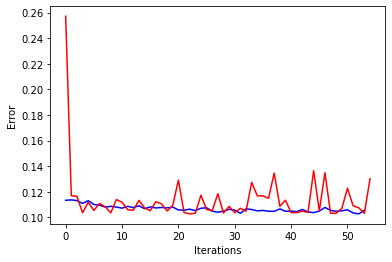

In [9]:
random.seed(0)
# Модуль настройки параметров pybrain использует модуль random; зафиксируем seed для получения воспроизводимого результата
trainer = BackpropTrainer(net, dataset=ds_train) # Инициализируем модуль оптимизации
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
line_train = plt.plot(err_train, 'b', err_val, 'r') # Построение графика
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')

Рассчитаем значение доли неправильных ответов на обучающей и контрольной выборке.

In [10]:
res_train = net.activateOnDataset(ds_train).argmax(axis=1) # Подсчет результата на обучающей выборке
error_train = percentError(res_train, ds_train['target'].argmax(axis=1)) # Подсчет ошибки
print(f'Error on train: {error_train} %') 

res_test = net.activateOnDataset(ds_test).argmax(axis=1) # Подсчет результата на тестовой выборке
error_test = percentError(res_test, ds_test['target'].argmax(axis=1)) # Подсчет ошибки
print(f'Error on test: {error_test} %')

Error on train: 51.29579982126899 %
Error on test: 46.666666666666664 %


### Определение оптимального числа нейронов.

hidden_neurons_num = 50; Error on train: 47.899910634495086 %; Error on test: 43.125 %
hidden_neurons_num = 100; Error on train: 44.32529043789098 %; Error on test: 41.041666666666664 %
hidden_neurons_num = 200; Error on train: 43.52100089365505 %; Error on test: 42.083333333333336 %
hidden_neurons_num = 500; Error on train: 39.94638069705094 %; Error on test: 37.708333333333336 %
hidden_neurons_num = 700; Error on train: 42.0017873100983 %; Error on test: 35.0 %
hidden_neurons_num = 1000; Error on train: 41.19749776586238 %; Error on test: 35.625 %
Число нейронов, при котором был минимум ошибки на тесте: 700


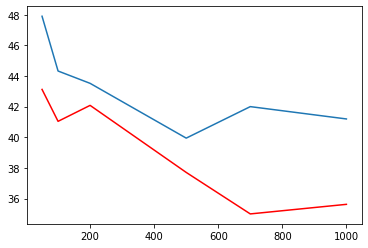

In [11]:
from pybrain.structure.modules import LinearLayer

random.seed(0) # Зафиксируем seed для получния воспроизводимого результата
np.random.seed(0)

def plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec):
# hidden_neurons_num -- массив размера h, содержащий количество нейронов, по которому предполагается провести перебор,
#   hidden_neurons_num = [50, 100, 200, 500, 700, 1000];
# res_train_vec -- массив размера h, содержащий значения доли неправильных ответов классификации на обучении;
# res_train_vec -- массив размера h, содержащий значения доли неправильных ответов классификации на контроле
    plt.figure()
    plt.plot(hidden_neurons_num, res_train_vec)
    plt.plot(hidden_neurons_num, res_test_vec, '-r')

hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
res_train_vec = list()
res_test_vec = list()

for nnum in hidden_neurons_num:
    # Put your code here
    net = buildNetwork(ds_train.indim, nnum, ds_train.outdim, outclass=SoftmaxLayer, hiddenclass = LinearLayer)
    init_params = np.random.random((len(net.params))) 
    net._setParameters(init_params)
    
    trainer = BackpropTrainer(net, dataset=ds_train) 
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
    
    res_train = net.activateOnDataset(ds_train).argmax(axis=1) 
    error_train = percentError(res_train, ds_train['target'].argmax(axis=1)) 

    res_test = net.activateOnDataset(ds_test).argmax(axis=1)
    error_test = percentError(res_test, ds_test['target'].argmax(axis=1)) 
    
    print(f'hidden_neurons_num = {nnum}; Error on train: {error_train} %; Error on test: {error_test} %')
    
    res_train_vec.append(error_train)
    res_test_vec.append(error_test)
    # Не забудьте про инициализацию весов командой np.random.random((len(net.params)))
    
# Постройте график зависимости ошибок на обучении и контроле в зависимости от количества нейронов
plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec)          

print(f'Число нейронов, при котором был минимум ошибки на тесте: {hidden_neurons_num[res_test_vec.index(min(res_test_vec))]}')